### **Fraud Detection Challenge** <br>
By: Rayan Roy

The dataset was acquired from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv#)
 which contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Our goal is to classify if a transaction is fraud, with 1 being Yes and 0 being No.




In [ ]:
!ls "/content/drive/My Drive"

Assignment_description.docx  credit_card_fraud_data.zip


In [ ]:
!unzip "/content/drive/My Drive/credit_card_fraud_data.zip"

Archive:  /content/drive/My Drive/DS_intern_interview/credit_card_fraud_data.zip
  inflating: creditcard.csv          


In [ ]:
!pip install sklearn
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
fraud_data = pd.read_csv("creditcard.csv")
fraud_data.head() # Loading data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Exploratory Data Analysis

In [ ]:
# We can see all the columns are numeric values
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
fraud_data.isnull().sum() # There are no null values present

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Lets explore how many values are fraud and how many are normal data. We can see there are 492 rows that are fraud while 284315 count that are normal. This is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

In [ ]:
fraud_data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Hypothesis or things I want to explore:
 
 Since there are only two variables time and amount that we know about, we will explore the two questions:
*   Are there certain amount/threshold that are being declared as fraud?
* Are there any trends in fraud/normal payment over time or any seasonality?
*   Are there any patterns between amount and time?

We don't know anything about the variables beginning with V1, so we won't be using them to explore their distribution.





Text(0, 0.5, 'No of transaction')

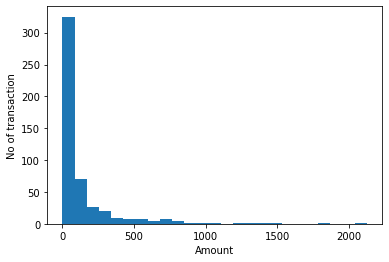

In [ ]:
# Exploring the threshold, we will draw a histogram to check
# Looking at the fraud data
plt.hist(fraud_data.Amount[fraud_data.Class == 1], bins=25)
plt.xlabel("Amount")
plt.ylabel("No of transaction")

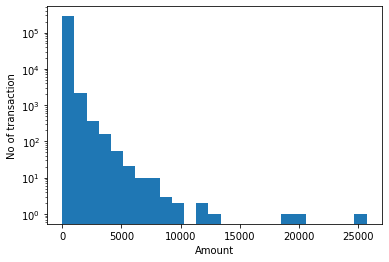

In [ ]:
# Looking at the normal data
plt.hist(fraud_data.Amount[fraud_data.Class == 0], bins=25)
plt.xlabel("Amount")
plt.ylabel("No of transaction")
plt.yscale('log')


We can see that most of the normal payments are concentrated between 0 to 10000 while most of the fraud payment are concentrated between 0 to 300


Text(0.5, 0, 'Time in seconds')

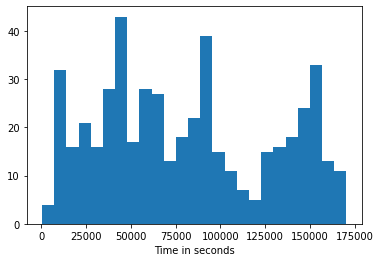

In [ ]:
plt.hist(fraud_data.Time[fraud_data.Class == 1], bins=25)
plt.xlabel("Time in seconds")

Text(0.5, 0, 'Time in seconds')

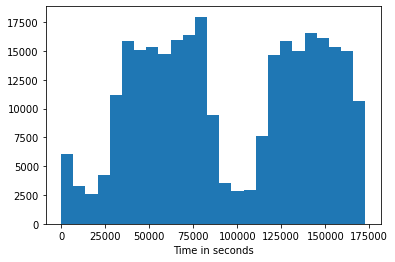

In [ ]:
plt.hist(fraud_data.Time[fraud_data.Class == 0], bins=25)
plt.xlabel("Time in seconds")

We can see from the histogram that fraud payments are cyclical in nature meaning that payments go up and down in certain time. From the normal payment, we see a bimodal distribution. An interesting observation is that there are max value is 175000 seconds for normal payment which is approximately 2 days. This indicates that payment are being monitored over 2 day period.

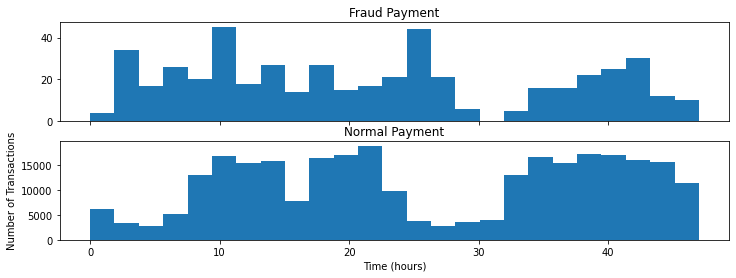

In [ ]:
# Lets explore them in hour basis. We will do a line plot at same time
fraud_data['Hour'] = fraud_data['Time'].apply(lambda x: np.floor(x / 3600))
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

ax1.hist(fraud_data.Hour[fraud_data.Class == 1], bins = 25)
ax1.set_title('Fraud Payment')
ax2.hist(fraud_data.Hour[fraud_data.Class == 0], bins = 25)
ax2.set_title('Normal Payment')

plt.xlabel('Time (hours)')
plt.ylabel('Number of Transactions')
plt.show()


We see that majority of the transactions happen during the day.

#### **Lets see any visible pattern between time and amount.**

Text(0, 0.5, 'Amount')

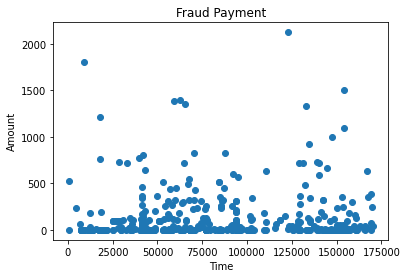

In [ ]:
plt.scatter(fraud_data.Time[fraud_data.Class == 1], fraud_data.Amount[fraud_data.Class == 1])
plt.title("Fraud Payment")
plt.xlabel("Time")
plt.ylabel("Amount")

Text(0, 0.5, 'Amount')

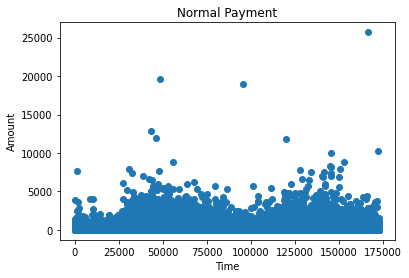

In [ ]:
plt.scatter(fraud_data.Time[fraud_data.Class == 0], fraud_data.Amount[fraud_data.Class == 0])
plt.title("Normal Payment")
plt.xlabel("Time")
plt.ylabel("Amount")

We don't see anything particular interesting.

## Model Performance:

We will split the data between train and test dataset (80-20 split). And we will split the train set into train and validation set.

In [ ]:
ylab = fraud_data['Class']
predictors = fraud_data.iloc[:,0:30]
X_train, X_test, Y_train, Y_test = train_test_split(predictors,ylab, stratify=ylab, 
                                                    test_size=0.2) # random shuffling
X_train, valid_train, Y_train, valid_test = train_test_split(X_train, Y_train, test_size=0.2, random_state= 202)

We will use various classifiers including random forest, XGBoost, Gradient Boost (GBM) and CatBoost and LightGBM. I didn't have much computing power to tune my hyperparameters. 

In [ ]:
# Random Forest Classifier:
rf = RandomForestClassifier(n_jobs = 10, # Using low power b/c don't have that much compute
                            verbose = False,
                             random_state = 443, # for reproducibility
                             criterion='gini',
                             n_estimators=50)

In [ ]:
rf.fit(X_train[predictors.columns], Y_train)

RandomForestClassifier(n_estimators=50, n_jobs=10, random_state=443,
                       verbose=False)

In [ ]:
# The most important metric of evaluation is ROC curve which plots the 
# true positive rate (TPR) versus the false positive rate (FPR).
# The higher the ROC score the better
pred = rf.predict(valid_train[predictors.columns])
roc_auc_score(valid_test.values, pred)


0.8799450476985976

XGB Classifier

In [ ]:
xgb1 = XGBClassifier(objective = 'binary:logistic', eval_metric = "logloss")
# Since classification eval is logloss

xgb1.fit(X_train[predictors.columns], Y_train)
pred = xgb1.predict(valid_train[predictors.columns])
roc_auc_score(valid_test.values, pred)

0.8799120763177561

Gradient Boosting Classifier:

In [ ]:
gbm = GradientBoostingClassifier()
gbm.fit(X_train[predictors.columns], Y_train)
pred = gbm.predict(valid_train[predictors.columns])
roc_auc_score(valid_test.values, pred)


0.806556762063862

Cat Boost:

In [ ]:
clf = CatBoostClassifier()
clf.fit(X_train[predictors.columns], Y_train)
pred = clf.predict(valid_train[predictors.columns])
roc_auc_score(valid_test.values, pred)

Learning rate set to 0.095119
0:	learn: 0.3753179	total: 103ms	remaining: 1m 42s
1:	learn: 0.2093795	total: 159ms	remaining: 1m 19s
2:	learn: 0.1152537	total: 216ms	remaining: 1m 11s
3:	learn: 0.0654819	total: 265ms	remaining: 1m 5s
4:	learn: 0.0399736	total: 315ms	remaining: 1m 2s
5:	learn: 0.0257348	total: 362ms	remaining: 59.9s
6:	learn: 0.0174439	total: 406ms	remaining: 57.6s
7:	learn: 0.0123680	total: 454ms	remaining: 56.3s
8:	learn: 0.0092814	total: 500ms	remaining: 55.1s
9:	learn: 0.0070863	total: 554ms	remaining: 54.8s
10:	learn: 0.0057767	total: 606ms	remaining: 54.5s
11:	learn: 0.0049313	total: 665ms	remaining: 54.7s
12:	learn: 0.0042879	total: 711ms	remaining: 54s
13:	learn: 0.0038396	total: 766ms	remaining: 53.9s
14:	learn: 0.0035045	total: 815ms	remaining: 53.5s
15:	learn: 0.0032272	total: 863ms	remaining: 53.1s
16:	learn: 0.0030501	total: 916ms	remaining: 53s
17:	learn: 0.0028600	total: 967ms	remaining: 52.7s
18:	learn: 0.0027494	total: 1.02s	remaining: 52.5s
19:	learn: 0

0.8865897334447034

LightGBM classifier:

In [ ]:
# LightGBM
lgbm = LGBMClassifier()
lgbm.fit(X_train[predictors.columns], Y_train)
pred = lgbm.predict(valid_train[predictors.columns])
roc_auc_score(valid_test.values, pred)

0.6244356032297299

Based on the ROC scores, it seems like the random forest gives the best predictions. We will use the catboost model to fit the test set.

But before that lets explore the features that important from the random forest model

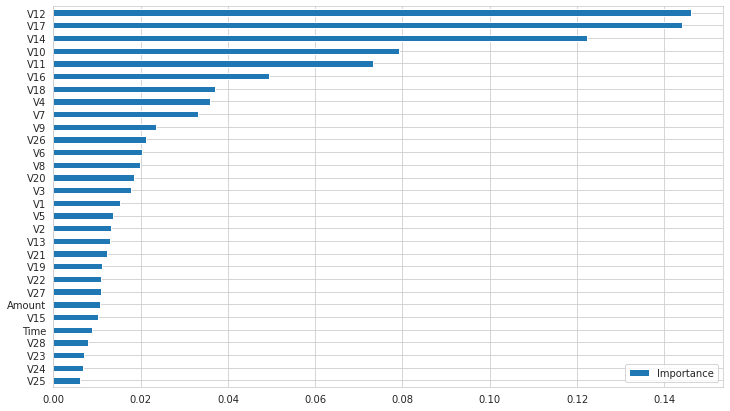

In [ ]:
fi = pd.DataFrame(clf.feature_importances_, index=predictors.columns, columns=['Importance'])
fi = fi.sort_values('Importance')
fi.plot.barh(figsize=(12,7))

Keeping a threshold of 0.6, we can see that V12, V17, V14, V10, V1 are the most important variables that are contributing to the prediction.

In [ ]:
pred = clf.predict(X_test[predictors.columns])
roc_auc_score(Y_test.values, pred)

0.8723786363166538

We see a high test prediction with ROC score = 0.872378 using the CatBoost model.